In [2]:
# Leon May
# 8.2 Assignment

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# ----------------------------
# 1. Load and reshape the data
# ----------------------------
CSV_PATH = r"C:\Users\pheno\OneDrive\Desktop\DSC630\us_retail_sales.csv"

df = pd.read_csv(CSV_PATH)

# Melt wide format 
month_map = {'JAN':1,'FEB':2,'MAR':3,'APR':4,'MAY':5,'JUN':6,
             'JUL':7,'AUG':8,'SEP':9,'OCT':10,'NOV':11,'DEC':12}

df_melt = df.melt(id_vars='YEAR', var_name='MONTH_ABBR', value_name='Sales')
df_melt['MONTH_ABBR'] = df_melt['MONTH_ABBR'].str.upper()
df_melt['Month'] = df_melt['MONTH_ABBR'].map(month_map)
df_melt = df_melt.dropna(subset=['Month', 'Sales']).sort_values(['YEAR','Month'])

# Build datetime index
dates = pd.to_datetime(dict(year=df_melt['YEAR'], month=df_melt['Month'], day=1))
ts = pd.Series(df_melt['Sales'].values, index=dates).sort_index()

# Clip to Jan 1992–Jun 2021 
ts = ts.loc['1992-01-01':'2021-06-01']
ts.index.freq = 'MS'


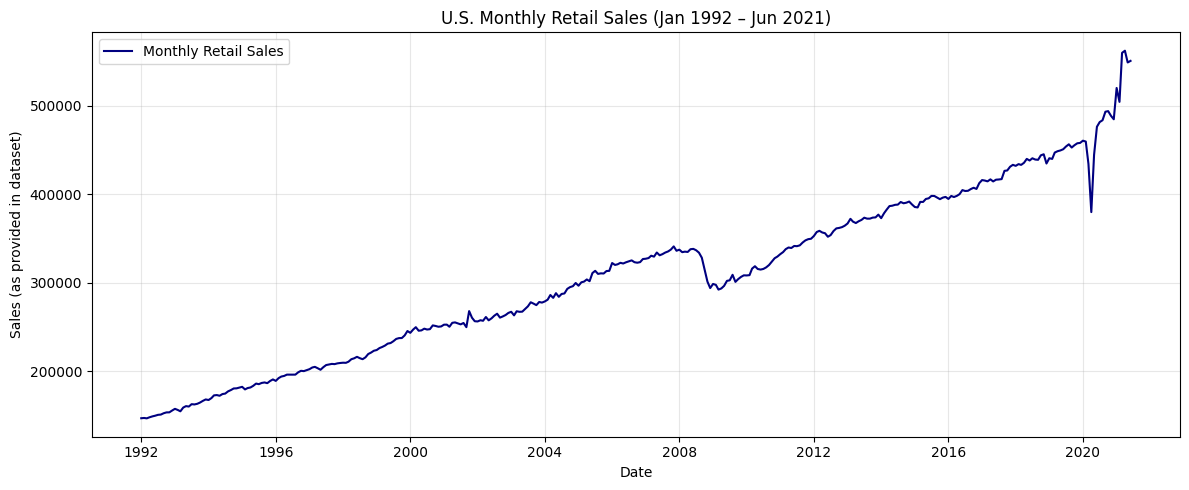


=== Quick Observations ===
Time span: 1992-01-01 → 2021-06-01  |  354 months total.
Average sales in 1992: 150,411
Average sales in 2020: 465,120
Overall growth ≈ 209.2% from 1992 → 2020.
Highest average sales months: ['Jun', 'May', 'Dec']


In [3]:
# ----------------------------
# 2. Plot with labels & observations
# ----------------------------
plt.figure(figsize=(12,5))
plt.plot(ts, label='Monthly Retail Sales', color='navy')
plt.title('U.S. Monthly Retail Sales (Jan 1992 – Jun 2021)')
plt.xlabel('Date')
plt.ylabel('Sales (as provided in dataset)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print("\n=== Quick Observations ===")
print(f"Time span: {ts.index.min().date()} → {ts.index.max().date()}  |  {len(ts)} months total.")
print(f"Average sales in 1992: {ts['1992'].mean():,.0f}")
print(f"Average sales in 2020: {ts['2020'].mean():,.0f}")
growth = (ts['2020'].mean()/ts['1992'].mean() - 1)*100
print(f"Overall growth ≈ {growth:.1f}% from 1992 → 2020.")
top_months = ts.groupby(ts.index.month).mean().sort_values(ascending=False).head(3)
print("Highest average sales months:", [pd.Timestamp(2000,m,1).strftime('%b') for m in top_months.index])


In [4]:
# ----------------------------
# 3. Split train/test sets
# ----------------------------
train = ts[:'2020-06']
test = ts['2020-07':'2021-06']


In [6]:
# ----------------------------
# 4. Fit Holt-Winters model
# ----------------------------
model = ExponentialSmoothing(
    train,
    trend='add',
    damped_trend=True,
    seasonal='mul',
    seasonal_periods=12,
    initialization_method='estimated'
)
fit = model.fit(optimized=True)
forecast = fit.forecast(len(test))
forecast.index = test.index



RMSE on test set (Jul 2020 – Jun 2021): 47,629.85


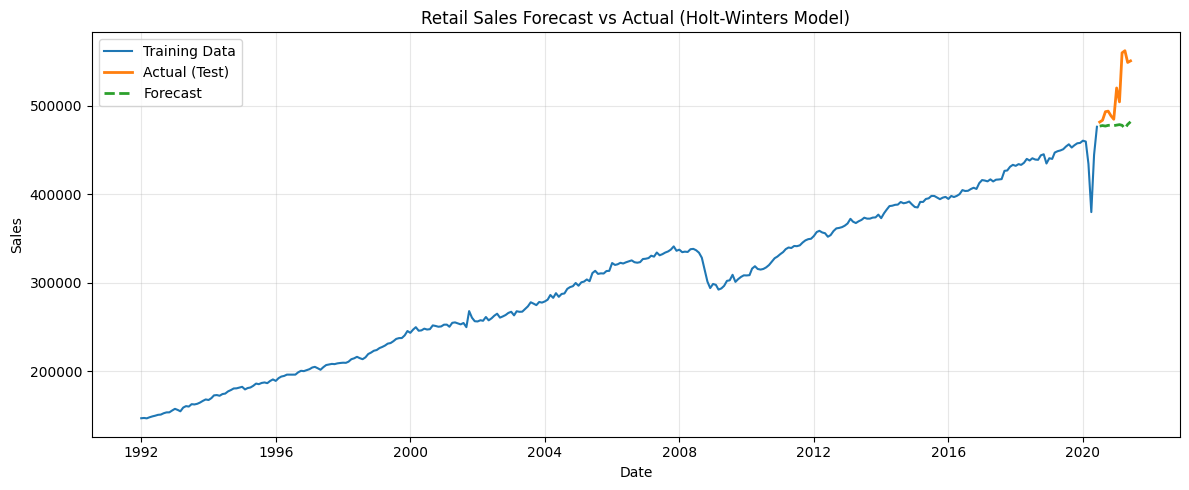

In [7]:
# ----------------------------
# 5. Evaluate RMSE and plot
# ----------------------------
rmse = np.sqrt(np.mean((forecast - test)**2))
print(f"\nRMSE on test set (Jul 2020 – Jun 2021): {rmse:,.2f}")

plt.figure(figsize=(12,5))
plt.plot(train, label='Training Data', linewidth=1.5)
plt.plot(test, label='Actual (Test)', linewidth=2)
plt.plot(forecast, label='Forecast', linestyle='--', linewidth=2)
plt.title('Retail Sales Forecast vs Actual (Holt-Winters Model)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()